In [465]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit import *
import random
import matplotlib.pyplot as plt
from operator import attrgetter
import heapq
from operator import itemgetter
from scipy.spatial.distance import cityblock

In [466]:
# Target & reward ------------------------------------------------------------------------

In [467]:
class Target:
    def __init__(self,name,x,y): # no indetermination in the target's position
        self.name = name
        self.x = x
        self.y = y

In [468]:
T = Target("T", 0.875, 0.125) # deep in the ocean

In [469]:
# the closer the target, the less the distance, the higher the reward
def reward(T, betax, betay):
    return 1 - ((T.x - betax)**2 + (T.y - betay)**2)**0.5

In [470]:
# Obstacles ----------------------------------------------------------------------------

In [471]:
class Obstacle: # Just a point for now
    def __init__(self,name,x,y):
        self.name = name
        self.x = x
        self.y = y

In [472]:
O = Obstacle("Oo", 0.001, 0.001) # deep in the ocean

In [473]:
# Robots -------------------------------------------------------------------------------

In [474]:
class Robotx(object):
    _registry = []

    def __init__(self, name, alphax, betax, alphay, betay, gamma, delta):
        self._registry.append(self)
        self.name = name
        self.alphax = alphax
        self.betax = betax
        self.alphay = alphay
        self.betay = betay
        delta = reward(T, betax, betay)
        gamma = 1 - delta
        self.gamma = gamma
        self.delta = delta
        self.arrows = []

In [475]:
# arbitrary number of robots that, at the start, are uniformly distributed in the square of side length radius*2,
# centered in starting_cluster_coord
#
num_of_robots = 2

# must be lower than 0.25, otherwise, the robots would start on different cells
radius = 0.05

# center of the (0,0) cell 
starting_cluster_coord = (0.125, 0.875)

a_x, a_y = 1-starting_cluster_coord[0]-radius, 1-starting_cluster_coord[0]+radius
b_x, b_y = 1-starting_cluster_coord[1]-radius, 1-starting_cluster_coord[1]+radius

for i in range(num_of_robots):
    x = random.uniform(a_x,a_y)
    y = random.uniform(b_x,b_y)
    Robotx('R'+str(i), x, 1-x, y, 1-y, 1 - reward(T, 1-x, 1-y), reward(T, 1-x, 1-y))

In [476]:
# note: values are stored with full precision, rounding is done only on visualization (with :.2f)

for k in Robotx._registry:
    print(f"{k.name} {k.betax:.2f} {k.betay:.2f} {k.gamma:.2f} {k.delta:.2f}")

R0 0.10 0.86 1.07 -0.07
R1 0.15 0.87 1.04 -0.04


In [477]:
for k in Robotx._registry:
    print(f"{k.name} {k.delta:.2f}")

R0 -0.07
R1 -0.04


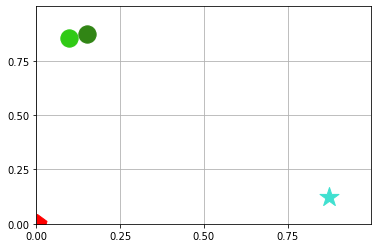

In [478]:
def plot_scatterplot():

    # to print grid on map
    ax = plt.figure().gca()
    ax.set_xticks(np.arange(0, 1, 0.25))
    ax.set_yticks(np.arange(0, 1., 0.25))
    plt.grid()

    for i in Robotx._registry:
        robot_color = hex(int("0x30ca15", 16) + int("0x00bb00", 16)*int(i.name[1])).replace("0x","#")
        plt.scatter(i.betax, i.betay, s = 300, marker = 'o', color = robot_color)
        
    plt.scatter(T.x, T.y, s = 400, marker = '*', color = 'turquoise')
    plt.scatter(O.x, O.y, s = 400, marker = 'p', color = 'red')

    plt.axis([0, 1, 0, 1])
    plt.show() 

plot_scatterplot()

In [479]:
for r in Robotx._registry:
    if (r.delta < 0.5):
        print(f"{r.name} {r.delta:.2f} achtung!") # and start from this point to build the reshuffle section

R0 -0.07 achtung!
R1 -0.04 achtung!


In [480]:
# Grover planner -------------------------------------------------------------------------    

In [481]:
# takes as input strings with the binary encoding of cells and outputs the manhattan distance between them
def manhattan(start_cell, target_cell):
    start_cell_v, target_cell_v = [int(b) for b in start_cell], [int(b) for b in target_cell]
    return int(cityblock(start_cell_v, target_cell_v).item())

In [482]:
class GroverPlanner:

    def XOR(self, qc, a, b, output):
        qc.cx(a, output)
        qc.cx(b, output)

    def encode_target(self, qc, target_cell, qubits):
        for idx, bit in enumerate(target_cell):
            bitn = int(bit)
            if not bitn:
                qc.x(qubits[idx])

    def diffuser(self, nqubits):
        diff = QuantumCircuit(nqubits)
        # Apply transformation |s> -> |00..0> (H-gates)
        for qubit in range(nqubits):
            diff.h(qubit)
        # Apply transformation |00..0> -> |11..1> (X-gates)
        for qubit in range(nqubits):
            diff.x(qubit)
        # Do multi-controlled-Z gate
        diff.h(nqubits - 1)
        diff.mct(list(range(nqubits - 1)), nqubits - 1)  # multi-controlled-toffoli
        diff.h(nqubits - 1)
        # Apply transformation |11..1> -> |00..0>
        for qubit in range(nqubits):
            diff.x(qubit)
        # Apply transformation |00..0> -> |s>
        for qubit in range(nqubits):
            diff.h(qubit)
        # We will return the diffuser as a gate
        U_s = diff.to_gate()
        U_s.name = "U$_\psi$"
        return U_s

    def oracle(self, num_of_M, target_cell, qc, pos_qubits, mov_qubits, c, output):

        if num_of_M == 1:
            # -- First M --
            self.XOR(qc, pos_qubits[1], mov_qubits[0], c[0])
            qc.x(c[0])
            self.XOR(qc, pos_qubits[0], mov_qubits[0], c[1])

            self.encode_target(qc, target_cell, [c[0], c[1]])
            qc.ccx(c[0], c[1], output)
            self.encode_target(qc, target_cell, [c[0], c[1]])

            # -- First M^-1 operator --
            self.XOR(qc, pos_qubits[0], mov_qubits[0], c[1])
            qc.x(c[0])
            self.XOR(qc, pos_qubits[1], mov_qubits[0], c[0])
        
        elif num_of_M == 2:

            # -- First M --
            self.XOR(qc, pos_qubits[1], mov_qubits[0], c[0])
            qc.x(c[0])
            self.XOR(qc, pos_qubits[0], mov_qubits[0], c[1])

            # -- Second M --
            self.XOR(qc, c[1], mov_qubits[1], c[2])
            qc.x(c[2])
            self.XOR(qc, c[0], mov_qubits[1], c[3])

            # -- Test operator --
            self.encode_target(qc, target_cell, [c[2], c[3]])
            qc.ccx(c[2], c[3], output)
            self.encode_target(qc, target_cell, [c[2], c[3]])

            # -- Second M^-1 operator --
            self.XOR(qc, c[0], mov_qubits[1], c[3])
            qc.x(c[2])
            self.XOR(qc, c[1], mov_qubits[1], c[2])

            # -- First M^-1 operator --
            self.XOR(qc, pos_qubits[0], mov_qubits[0], c[1])
            qc.x(c[0])
            self.XOR(qc, pos_qubits[1], mov_qubits[0], c[0])
    
    def find_path(self, start_cell, target_cell):

        # number of M operators is equal to the Manhattan distance between start and target
        num_of_M = manhattan(start_cell, target_cell)

        # --- Initializations ---
        pos_qubits = QuantumRegister(2, name="r")
        mov_qubits = QuantumRegister(num_of_M, name="m")
        c = QuantumRegister(2*num_of_M, name="c")
        output = QuantumRegister(1, name="q")
        cbits = ClassicalRegister(2+num_of_M, name="cbits")

        qc = QuantumCircuit(pos_qubits, mov_qubits, c, output, cbits)

        qc.h(pos_qubits)

        # initialize mov_qubits in state |s>
        qc.h(mov_qubits)

        # initialize 'output0' in state |->
        qc.initialize([1, -1] / np.sqrt(2), output)

        # --- Oracle + Diffuser ---
        num_iterations = 1
        for _ in range(num_iterations):
            self.oracle(num_of_M, target_cell, qc, pos_qubits, mov_qubits, c, output)
            diff_qubits = [0, 1, 2] if num_of_M == 1 else [0, 1, 2, 3]
            qc.append(self.diffuser(2+num_of_M), diff_qubits)

        # --- Measurement ---
        qc.measure(pos_qubits, cbits[0:2])
        qc.measure(mov_qubits, cbits[2:(2+num_of_M)])

        # --- Simulation ---
        aer_sim = Aer.get_backend("aer_simulator")
        transpiled_qc = transpile(qc, aer_sim)
        result_counts = aer_sim.run(transpiled_qc).result().get_counts()

        return [k for k in result_counts.keys() if k[-2:] == start_cell]

groverPlanner = GroverPlanner()


In [483]:
# test
groverPlanner.find_path(start_cell="00", target_cell="11")

['0000', '1100']

In [484]:
# Centroid handling -------------------------------------------------------------------------

Centroids:
{ (0.125, 0.875): ('00', '00') 
  (0.375, 0.875): ('01', '00') 
  (0.625, 0.875): ('00', '01') 
  (0.875, 0.875): ('01', '01') 
  (0.125, 0.625): ('10', '00') 
  (0.375, 0.625): ('11', '00') 
  (0.625, 0.625): ('10', '01') 
  (0.875, 0.625): ('11', '01') 
  (0.125, 0.375): ('00', '10') 
  (0.375, 0.375): ('01', '10') 
  (0.625, 0.375): ('00', '11') 
  (0.875, 0.375): ('01', '11') 
  (0.125, 0.125): ('10', '10') 
  (0.375, 0.125): ('11', '10') 
  (0.625, 0.125): ('10', '11') 
  (0.875, 0.125): ('11', '11') }


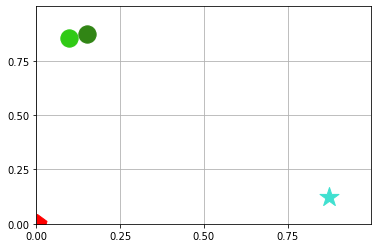

In [485]:
# returns a dict so that:
#  - the keys are the coordinates of the centroids of a square dim_map x dim_map map of side length 1
#  - the values are in the form (micro_cell, macro_cell) of the centroids
def find_centroids(dim_map):

    unit_displacement = 1 / (dim_map*2)

    centroids_coords = []
    for i in range(dim_map,0,-1):
        row = []
        for j in range(dim_map): 
            row.append((j*unit_displacement*2 + unit_displacement, i*unit_displacement*2 - unit_displacement))
        centroids_coords.append(row)

    centroids_dict = {t: (f"{str(i%2)}{str(j%2)}", f"{0 if t[1] > 0.5 else 1}{0 if t[0] < 0.5 else 1}")
     for i,row in enumerate(centroids_coords) for j,t in enumerate(row)}
     
    return centroids_dict

centroids = find_centroids(4)

print("Centroids:\n{ " + "\n  ".join(f"{k}: {v} " for k, v in centroids.items()) + "}")
plot_scatterplot() # for commodity

In [486]:
# returns the centroid of the cell that a point of coordinates (x,y) is located in
def find_closest_centroid(centroids, x, y):
    centroids_coords = np.array(list(centroids.keys()))
    distances = np.linalg.norm(centroids_coords-np.array([x, y]), axis=1)
    return centroids[tuple(centroids_coords[np.argmin(distances)])]
    
for r in Robotx._registry:
    print(f"Closest centroid to {r.name}: {find_closest_centroid(centroids, r.betax, r.betay)}")

Closest centroid to R0: ('00', '00')
Closest centroid to R1: ('00', '00')


In [487]:
# Reshuffling ----------------------------------------------------------------------------

In [488]:
# returns a list with the micro and macro displacement after the movement
def eval_displacement(old_centroid, new_centroid):
    old_c_micro, old_c_macro = old_centroid
    new_c_micro, new_c_macro = new_centroid

    return [manhattan(old_c_micro, new_c_micro), manhattan(old_c_macro, new_c_macro)]


In [489]:
def get_keys_from_value(dict, val):
    return [k for k, v in dict.items() if v == val]

In [490]:
result = all(i.delta < 0.8 for i in Robotx._registry)
print("Do all the robots have a reward lower than 0.8? : " + str(result))

# if True: reshuffle positions
# if False: do nothing

arrows = []

if result == True:
    flag = True
    while flag:
        flag = False
        for i in Robotx._registry:

            old_centroid = find_closest_centroid(centroids, i.betax, i.betay)
            # virtual_betax, virtual_betay = 1 - np.random.uniform(0,0.9), 1 - np.random.uniform(0,0.9)

            i.alphax = np.random.uniform(0,0.9)
            i.betax = 1 - i.alphax
            i.alphay = np.random.uniform(0,0.9)
            i.betay = 1 - i.alphay

            new_centroid = find_closest_centroid(centroids, i.betax, i.betay)

            displacement = eval_displacement(old_centroid, new_centroid)

            # macro movement
            if displacement[0] == 0 and displacement[1] != 0:
                print(f"{i.name}: macro")
                evaluated_path = groverPlanner.find_path(old_centroid[1], new_centroid[1])
                print(f"{i.name} evaluated path: {evaluated_path[0][:-2]}")


            # micro movement
            elif displacement[0] != 0 and displacement[1] == 0:
                print(f"{i.name}: micro")
                evaluated_path = groverPlanner.find_path(old_centroid[0], new_centroid[0])
                print(f"{i.name} evaluated path: {evaluated_path[0][:-2]}")

            
            # macro and micro movement
            elif displacement[0] != 0 and displacement[1] != 0:
                print(f"{i.name}: macro-micro")
                # macro path
                evaluated_path = groverPlanner.find_path(old_centroid[1], new_centroid[1])
                print(f"{i.name} evaluated path (macro): {evaluated_path[0][:-2]}")
            

                # micro path
                evaluated_path = groverPlanner.find_path(old_centroid[0], new_centroid[0])
                print(f"{i.name} evaluated path (micro): {evaluated_path[0][:-2]}")
               
                        

            # if (i.betax - O.x <= 0.2 and i.betay - O.y <= 0.2):
            #     flag = True

Do all the robots have a reward lower than 0.8? : True
R0: macro-micro
R0 evaluated path (macro): 00
R0 evaluated path (micro): 1
R1: macro-micro
R1 evaluated path (macro): 1
R1 evaluated path (micro): 1


In [491]:
for i in Robotx._registry: # recalculate the rewards
    i.delta = reward(T, i.betax, i.betay)
    i.gamma = 1 - i.delta
    print(f"{i.name} {i.delta:.2f}")

R0 0.66
R1 0.21


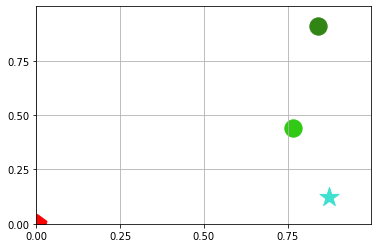

In [492]:
plot_scatterplot()